<a href="https://colab.research.google.com/github/dustiny5/DS-Unit-2-Sprint-2-Regression/blob/master/module3-regression-diagnostics/regression-diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Regression Diagnostics

Whenever you undertake regression analysis of any kind you should run diagnostic tests that check the shape of your data and the fit of your model to that data. 

## Not common in predictive modeling

You won't see many Kaggle competitions running these tests because they aren't as important for predictive modeling. There are less important (and sometimes completely ignored) in predictive modeling because the end-all be-all of predictive modeling is how accurate your model's predctions are on an "out of sample" dataset. This is why we split our dataset into two random halves and and then fit our model parameters using one half, and test the accuracy of our model's predictions using the other half. (It doesn't have to be 50-50 necessarily, but just an example.)

## Necessary for inferential regression modeling

However, if you ever need to run regression analysis for the purposes of inferentital modeling --because you intend to interpret and be informed by variable coefficients --these tests are of utmost importance. Each of these tests exists to test a certain assumption that we're making about the shape of our data or our model's fit to it. If one or multipile of these assumptions are violated, then doubt is cast on the reliability of our variable coefficients. 

# Estimating Parameters

You'll remember that OLS and Gradient-Descent based methods of linear regression modeling both seek to **estimate** parameters that "minimize the sum of the squared error." Because we have been more focused on predictive modeling we haven't talked as much about what it means for a parameter to be an "estimate."

An estimated regression coefficient represents the **mean** change in our response variable (y) given a one unit change in our response given a one unit change in the predictor. But because it is an estimate, there is a certain confidence interval around our prediction of our coefficient. The confidence interval is vital to our interpretation of regression coefficients.

## A Parameter Estimation Example

Suppose I was fitting a regression model and calculated its coefficients and substituted them into the equation:

\begin{align}
\hat{y} = .42+ 2.05x
\end{align}

We've well established in past lectures that $\hat{\beta}_1$ reprents the slope of our regression line, but we haven't talked about how this is just an **estimate** for the slope of our regression line, and as an estimate has an associated confidence interval.

Lets say that we calculated the 95% confidence interval for $\hat{\beta}_1$ and it came out to be $(1.9 ,  2.2)$. This means that we can only be 95% confident that the average effect of x on y is within this range. Up to this point we have just taken the reported coefficient as gospel, but a lot of conditions need to be satisfied in order for us to trust regression coefficients. We'll talk about a few of them today. 

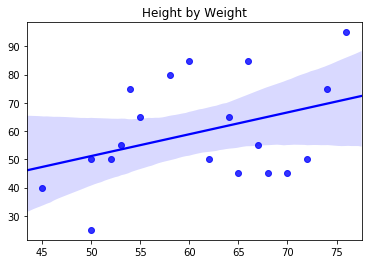

In [2]:
# We can create scatterplots that show the confidence interval!

heights = np.array([50,52,53,54,58,60,62,64,66,67, 68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,45,45,50,75,95,65,50,40,45])

sns.regplot(heights, weights, color='blue').set_title('Height by Weight');

![Constellations](https://www.explainxkcd.com/wiki/images/9/91/linear_regression.png)

## Standard Error of a Coefficient

While we can calculate a 95% confidence interval for any estimated parameter, we usually won't refer to the potential spread of parameter estimates by its confidence interval. We'll usually refer to how wide or how narrow the spread is by referring to what's called the "Standard Error." 

The Standard Error (SE) of a coefficient estimate is the estimated standard deviation of the error in measuring it. So the coefficient itself is the **estimated mean effect** of x on y. and the Standard Error is the **estimated standard deviation** of our coefficient. We use standard errors to calculate the confidence interval. 

## Standard Error of the Regression

The standard error of a coefficient is different from the standard error of the regression. The standard error of the regression as a whole is the average distance that points fall from the regression line. 

\begin{align}
SE_{est} = \sqrt{\frac{\sum(y_i-\hat{y})^2}{N}}
\end{align}

Does the numerator of that equation look familiar to you? I hope it does by now.

Standard Error of the regression as a whole is the average distance that datapoints fall from the regression line. 

## Precision vs Accuracy

![Accuracy vs Precision](https://www.dnasoftware.com/wp-content/uploads/2015/07/targets.png)

### Accuracy
A regression coefficient that is "Accurate" is centered around its "true" value. The problem here is that we don't know what the true value actually is, so when we say that a coefficient is more accurate we mean that we suspect that it better represents ground truth.  

The more observations we have, the more precise our estimates will be.

### Precision
A regression coefficient that is "Precise" has a small standard error. It has a tighter confidence interval as well.

# Gauss Markov Assumptions

There are five Gauss Markov assumptions (also called conditions) that are required for OLS to be BLUE (the "Best Linear Unbiased Estimator"). 

**0) Well Defined:** $X^{T}X$ is invertible (No perfect multicollinearity), $|X| \neq 0$

**1) Linearity:** the parameters we are estimating using the OLS method must be themselves linear.

**2) Random:** our data must have been randomly sampled from the population.

**3) Non-Collinearity:** the regressors (x vars) being calculated aren’t perfectly (or highly) correlated with each other.

**4) Exogeneity:** the regressors (x vars) aren’t correlated with the error term.

- Omitted Variables Bias (Ice Cream Sales and Burglaries)
- Instrumental Variables: A regression of education on earnings would be biased both education and ability are both influenced by  influenced by natural ability. We use an additional "Instrumental Variable" that is correlated with of schooling and earnings but isn't correlated with ability in order to estimate the effect of years of schooling on earnings. (Month of birth - Angrist and Kreuger) 

**5) Homoskedasticity:** no matter what the values of our regressors might be, the error of the variance is constant.

[Statistics How To - Gauss Markov Assumptions](https://www.statisticshowto.datasciencecentral.com/gauss-markov-theorem-assumptions/)


# Enough Terminology Zoo, Lets Do Stuff!

# Finding Standard Errors of Coefficients

Scikit-Learn is built to be a machine learning library, and machine learning typically prioritizes making accurate predictions over interpreting model parameters. Due to this, there aren't any easy ways to calculate standard errors of our coefficients using Sklearn. We'll need to use a different library called **statsmodels**.

### Preliminary steps

In [3]:
# Read in dataset 
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv")
df.columns.tolist()

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [4]:
# Most homes weren't renovated
df['yr_renovated'].value_counts().head()

0       20699
2014       91
2013       37
2003       36
2000       35
Name: yr_renovated, dtype: int64

In [0]:
# Drop columns that I don't care about
df = df.drop(columns=['id','date','zipcode','lat','long','yr_renovated'])

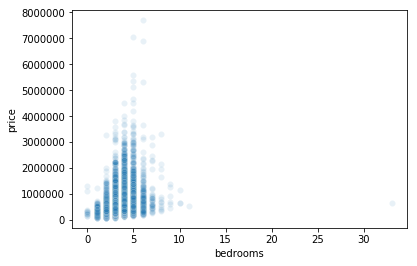

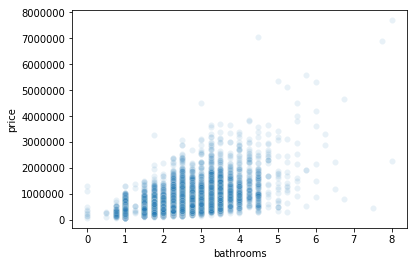

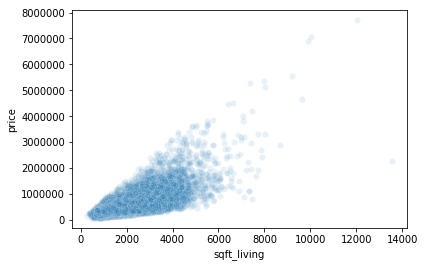

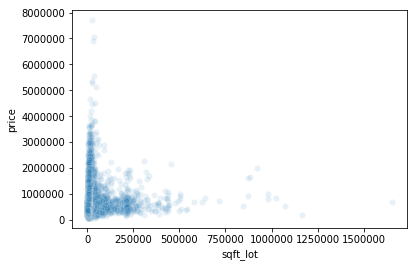

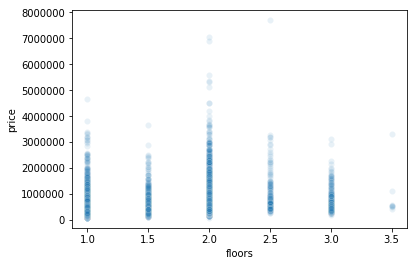

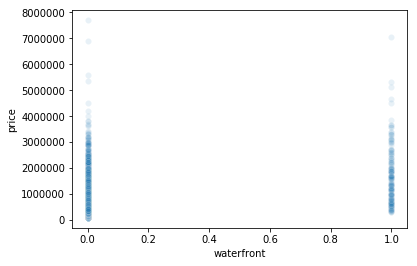

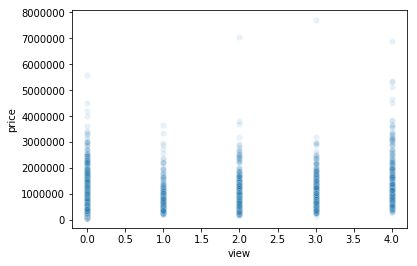

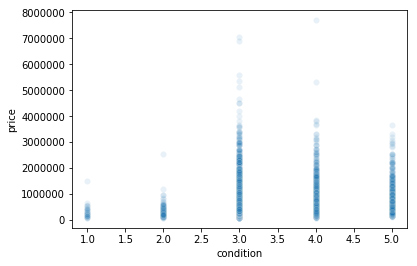

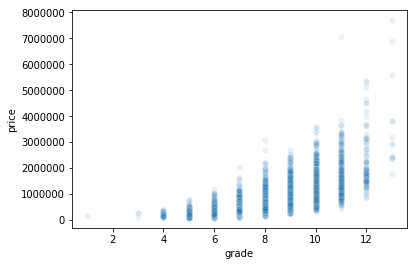

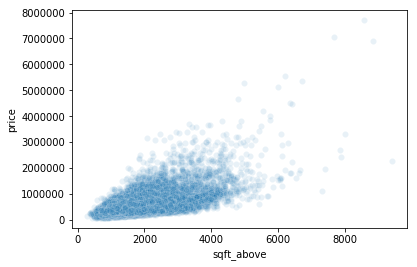

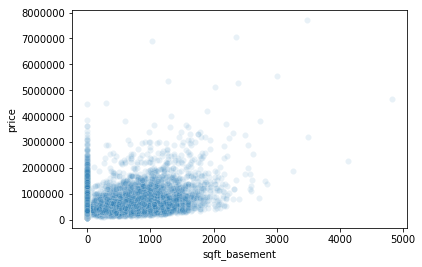

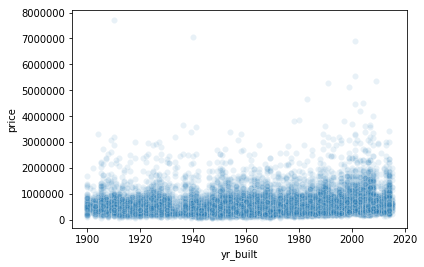

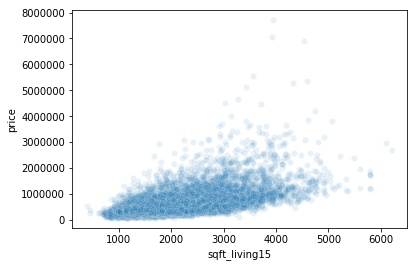

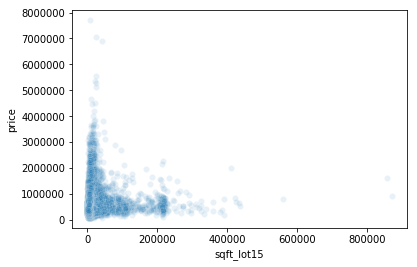

In [6]:
# Plot scatterplots
target = 'price'
features = df.columns.drop(target)
for feature in features:
    sns.scatterplot(x=feature, y=target, data=df, alpha=0.1)
    plt.show()

In [0]:
# Prepare X and y
target = 'price'
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
            'floors', 'waterfront', 'view', 'condition', 'grade', 
            'sqft_above', 'sqft_basement', 'yr_built', 
            'sqft_living15', 'sqft_lot15']

X = df[features] 
y = df[target]

In [8]:
# Use Statsmodels to run a regression
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3135.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        16:06:14   Log-Likelihood:            -2.9615e+05
No. Observations:               21613   AIC:                         5.923e+05
Df Residuals:                   21599   BIC:                         5.924e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.312e+06   1.31e+05     48.200

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Interpretation of P-Value

"The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable." [Minitab Blog](http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients)

## Remove Outliers

In [9]:
print(df.shape)
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(df.shape)

(21613, 15)
(19628, 15)


In [10]:
# Re-run regression without outliers.
X = df[features] 
y = df[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2290.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        16:06:14   Log-Likelihood:            -2.6196e+05
No. Observations:               19628   AIC:                         5.240e+05
Df Residuals:                   19615   BIC:                         5.241e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.279e+06   9.87e+04     53.471

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Log-Linear Regression

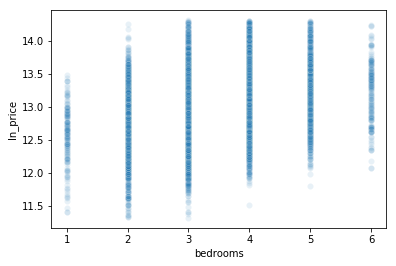

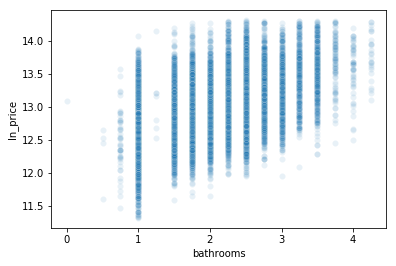

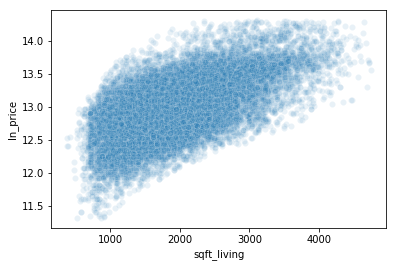

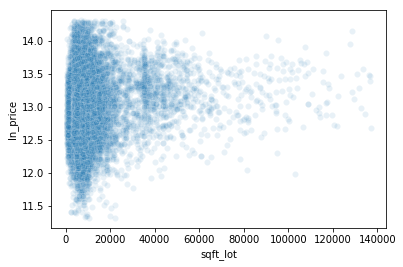

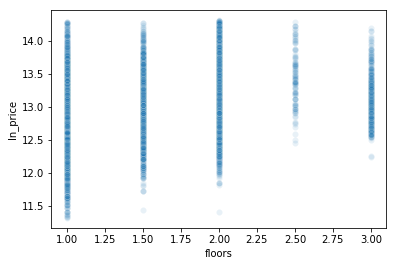

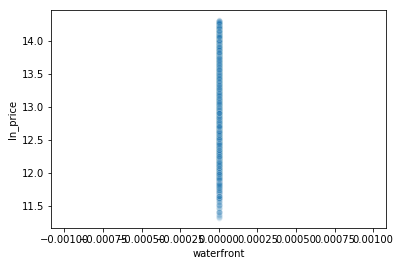

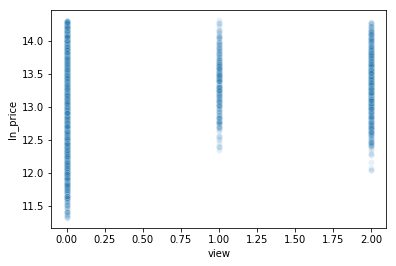

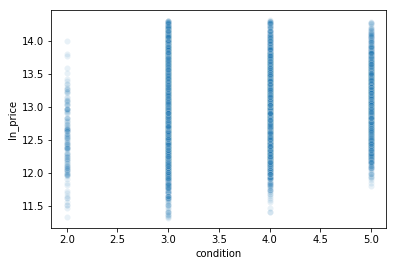

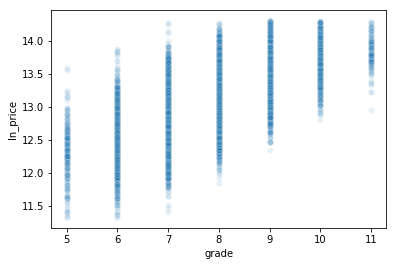

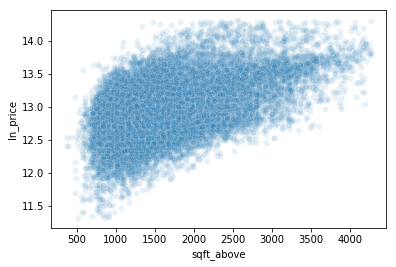

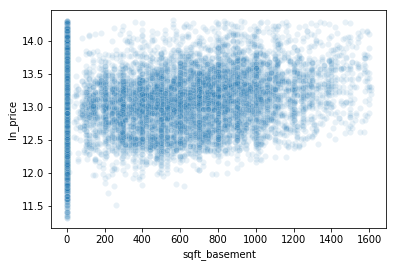

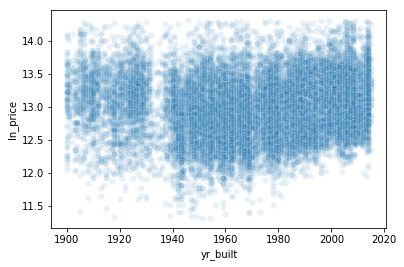

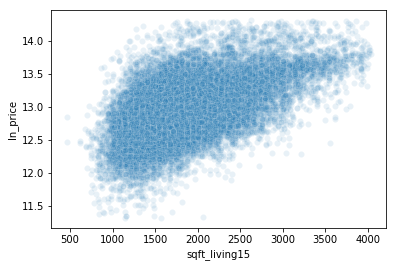

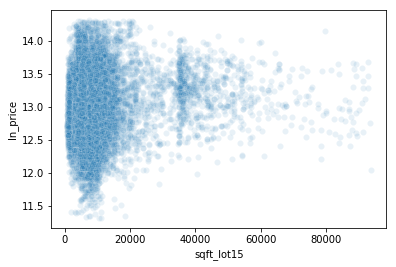

In [11]:
df['ln_price'] = np.log(df['price'])
df = df.drop(columns='price')

target = 'ln_price'
features = df.columns.drop(target)
for feature in features:
    sns.scatterplot(x=feature, y=target, data=df, alpha=0.1)
    plt.show()

In [12]:
# Log-Linear Regression
X = df[features] 
y = df[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2185.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        16:06:21   Log-Likelihood:                -4401.6
No. Observations:               19628   AIC:                             8829.
Df Residuals:                   19615   BIC:                             8932.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.7895      0.197    110.327

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[King County](https://www.google.com/maps/place/King+County,+WA/@47.4269284,-122.9244266,8z/data=!3m1!4b1!4m5!3m4!1s0x54905c8c832d7837:0xe280ab6b8b64e03e!8m2!3d47.5480339!4d-121.9836029)

# Collinearity/Multicollinearity

When two variables are close to being a linear combination of each other we call this **collinearity** or having high levels of collinearity. If there are three of more variables all with significant levels of collinearity we call this "multicollinearity" but people basically use the two terms interchangeably. 

## Perfect Multicollinearity
Variables variables are **perfectly** collinear when the vectors that represent them are linearly dependent. This means that if plotted against each other in a scatter plot all of the points would fall on the same line. We mentioned briefly that perfect multicollinearity breaks OLS because it makes it so that the X matrix is not invertible. 

Perfect multicollinearity usually is caused by careless feature engineering usually through transforming the units of a variable and then keeping both variables in the regression. It can also be created through the one-hot-encoding of binary categorical variables. 

## Why is Collinearity Bad? 

High levels of Collinearity in a dataset is bad because it increases standard errors and therefore makes estimates of our coefficients less precise. Very high levels of collinearity (nearing perfect multicollinearity can cause standard errors to grow drastically.) 

### Example of two collinear features:

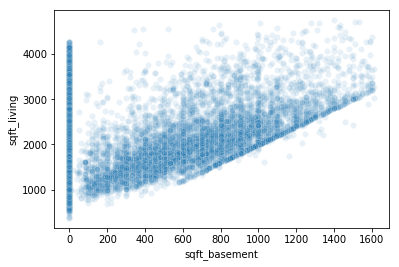

In [13]:
sns.scatterplot(x='sqft_basement', y='sqft_living', data=df, alpha=0.1);

## Testing for high levels of collinearity

We test for high levels of collinearity by calculating the dataset's **Variance Inflation Factor** or VIF. From Wikipedia:

> "In statistics, the variance inflation factor (VIF) is the ratio of variance in a model with multiple terms, divided by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity." [VIF Wikipedia](https://en.wikipedia.org/wiki/Variance_inflation_factor)

As a rule of thumb any variable that has a VIF > 10 needs to be dealt with (probably dropped from your model). If you see a VIF greater than 10 it is likely that two x variables are highly correlated. Remember that we can use the correlation matrix to check levels of correlation between our independent variables.

(Ignore the variance inflation factor for the constant. It should be high, even infinite.)

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const            8344.691191
bedrooms            1.700256
bathrooms           3.010785
sqft_living              inf
sqft_lot            3.045961
floors              2.082484
waterfront               NaN
view                1.063308
condition           1.202054
grade               2.696954
sqft_above               inf
sqft_basement            inf
yr_built            1.911507
sqft_living15       2.718360
sqft_lot15          3.110850
dtype: float64

### Exclude collinear features and refit model 

In [15]:
target = 'ln_price'
features = ['bedrooms',
            'bathrooms',
            'sqft_living',
            'sqft_lot',
            'floors',
            'waterfront',
            'view',
            'condition',
            'grade',
            'yr_built',
            'sqft_living15',
            'sqft_lot15']

y = df[target]
X = df[features]
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const            8181.955905
bedrooms            1.699934
bathrooms           2.879614
sqft_living         4.393925
sqft_lot            3.042852
floors              1.675151
waterfront               NaN
view                1.049483
condition           1.198524
grade               2.681403
yr_built            1.881612
sqft_living15       2.589906
sqft_lot15          3.105799
dtype: float64

In [16]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     2339.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        16:06:22   Log-Likelihood:                -4508.4
No. Observations:               19628   AIC:                             9041.
Df Residuals:                   19616   BIC:                             9135.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.1935      0.197    112.872

# Homoskedasticity and Heteroskedasticity

What a big complicated words. Also, some poeple spell them "homoscedasticity" and "heteroscedasticity" but that just feels wrong to me somehow.

## Homoskedasticity

Homoskedasticity means that along our entire domain (x axis) the residuals are about the same distance from our regression line (on average).

## Heteroskedasticity.

Our data points exhibit heteroskedasticity when they don't exhibit homoskedasticity. This is much easier to explain by just showing a picture.

![Homoskedasticity and Heteroskedasticity](https://www.researchgate.net/profile/Akhmad_Fauzy/publication/319091775/figure/fig2/AS:526826008846336@1502616516067/Example-of-homoscedasticity-Ideally-residuals-are-randomly-scattered-around-0-the.png)

Looking at scatterplots of our data are there any places where we might be worried about heteroskedasticity?

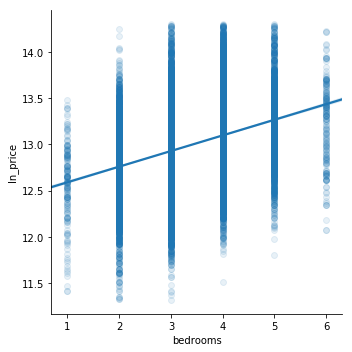

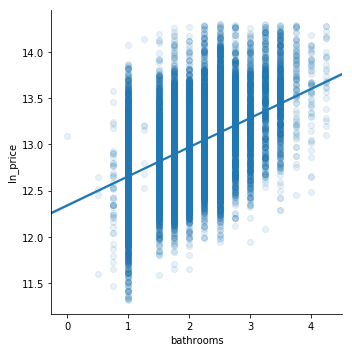

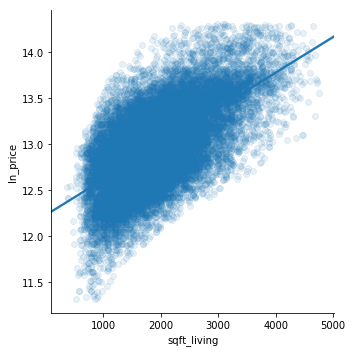

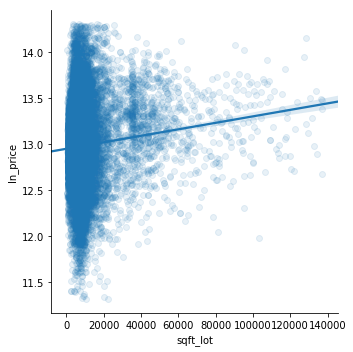

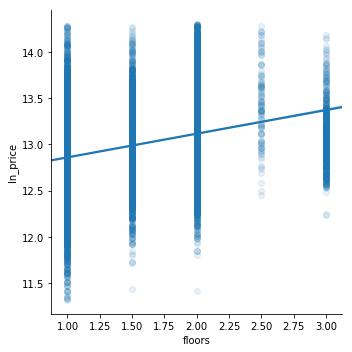

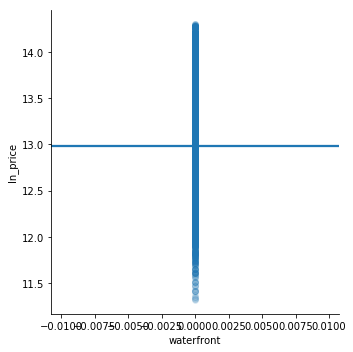

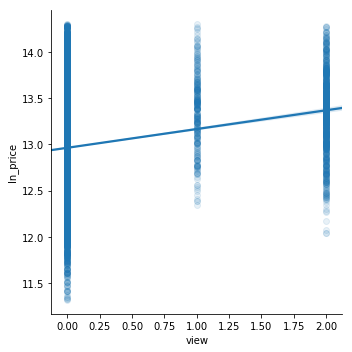

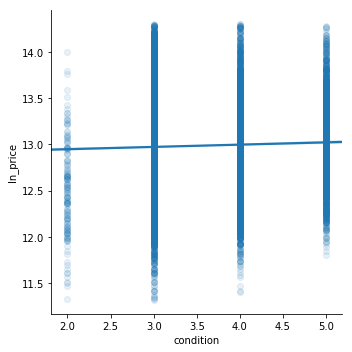

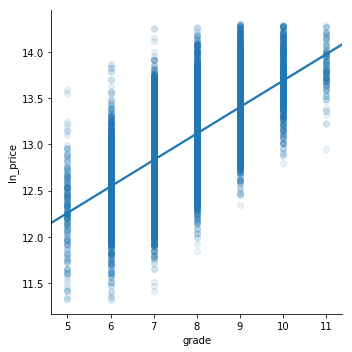

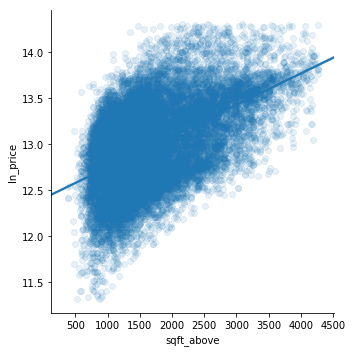

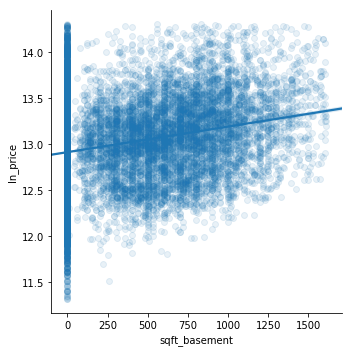

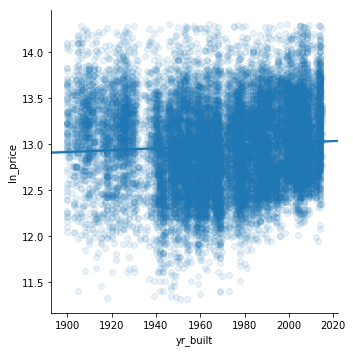

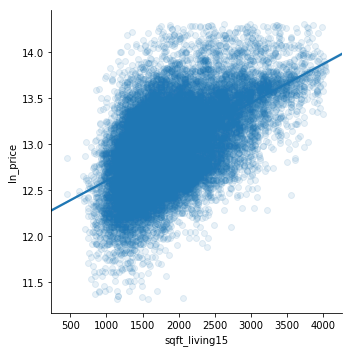

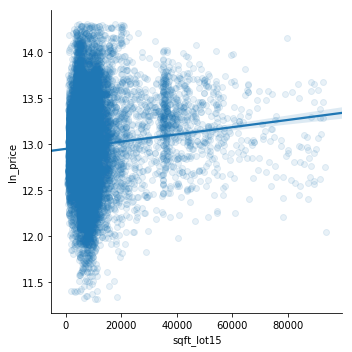

In [17]:
target = 'ln_price'
features = df.columns.drop(target)
for feature in features:
    sns.lmplot(x=feature, y=target, data=df, scatter_kws=dict(alpha=0.1))
    plt.show()

## Which variables might potentially be offenders? 

## Addressing Heteroskedasticity

If heteroskedasticity exists in our dataset it will damage our standard errors and make our estimates less precise. You have to remember that any challenges that damages the reliability of standard errors also damages the reliability of confidence intervals and hypothesis tests. Therefore, these challenges that damage standard errors also damage a whole host of statistical tools that we would normally like to rely on.

Dealing with heteroskedasticity is pretty straightforward, we simply employ what are called "robust standard errors" I won't go into depth on how they this works here, but robust standard errors essentially correct heteroskedasticity in our data while the side effects are minimal. Due to this if you are suspicious of heteroskedasticity in your dataset and you intend to interpret the coefficients of your model. You should run the regression using robust standard errors the majority of the time. Lets see how much our regression output changes when we use robust standard errors.


In [27]:
# Let's run our regression again using Robust Standard Errors
# cov_type='HC3' parameter to .fit() function

# Log-Linear Regression

X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 
       'sqft_living15', 'sqft_lot15']] 

y = df['ln_price']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2283.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        17:54:41   Log-Likelihood:                -4401.6
No. Observations:               19628   AIC:                             8829.
Df Residuals:                   19615   BIC:                             8932.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.7895      0.197    110.872

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


# Function Form Misspecification

Say we wanted to fit a polynomial log-linear model to this data. How might we identify (besides visually) potential candidates for polynomial functions? First off, what does the eyeball test point out might be potential candidates for polynomial forms? Here come scatter plots again.

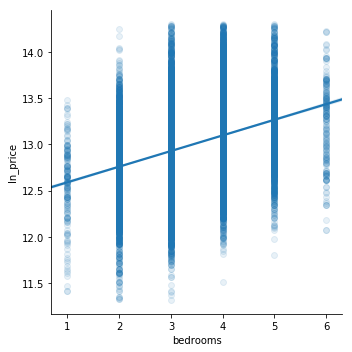

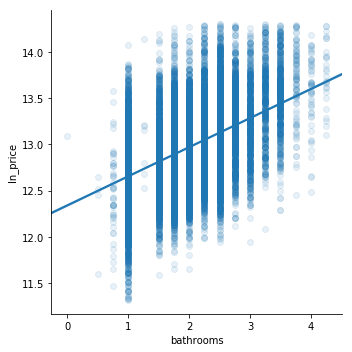

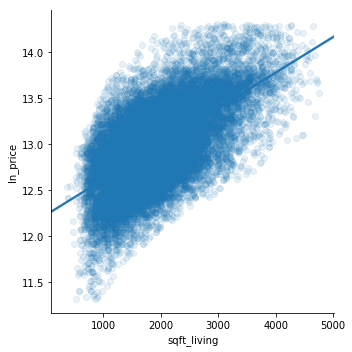

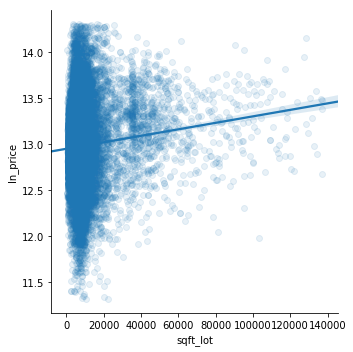

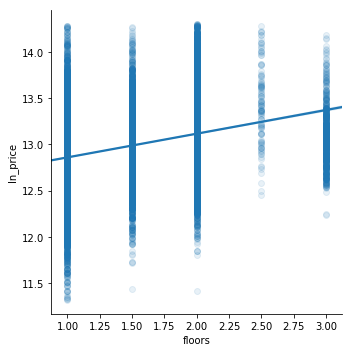

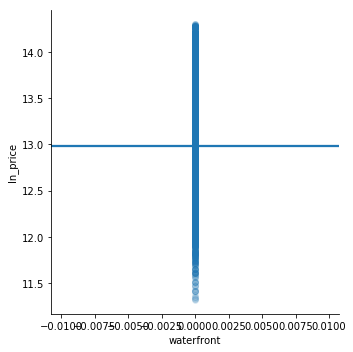

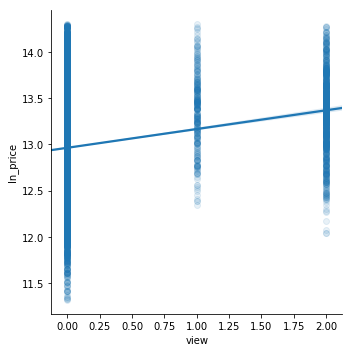

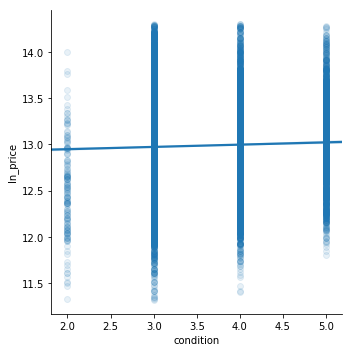

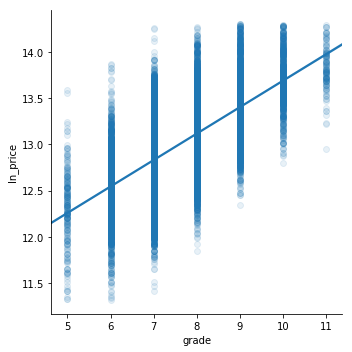

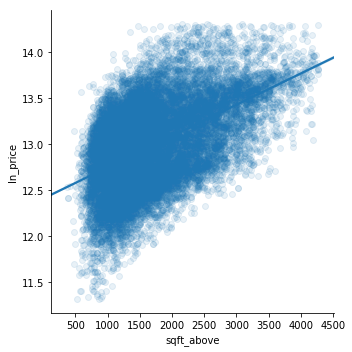

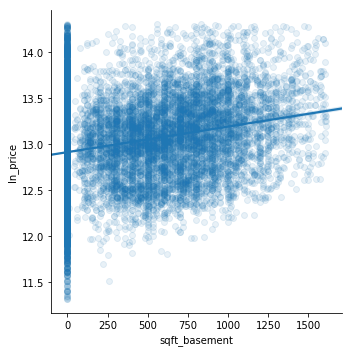

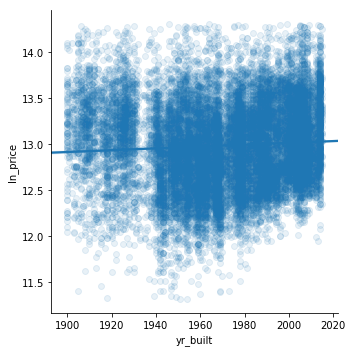

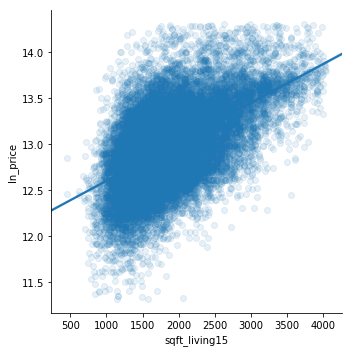

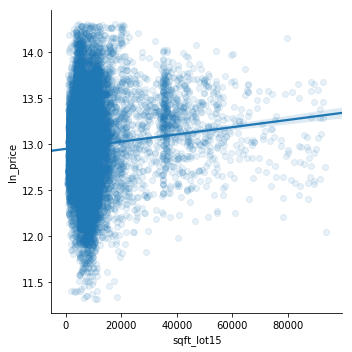

In [19]:
target = 'ln_price'
features = df.columns.drop(target)
for feature in features:
    sns.lmplot(x=feature, y=target, data=df, scatter_kws=dict(alpha=0.1))
    plt.show()

I think sqft_living and sqft_above at a minimum are potential candidates for polynomial terms. I want to remind you what an underfit linear regression looks like: 

![Underfitting](https://cdn-images-1.medium.com/max/1200/1*2RXJ2O-_c2ukaq5p-WQ9tQ.png)

This shows that the residuals of an underfit curved functional form will oscilate from negative residuals, to positive and then back to negative. 

We might expect the residual plot to look something like this:

![Underfit Residual graph](http://www.ryanleeallred.com/wp-content/uploads/2019/01/Underfit-Residual-Graph.png)

Truly, any bowing in our residuals is cause for concern. Lets plot the actual distribution of the residual graphs and see if our residuals match our eyeball test.

# Residual Plots

Plotting our residuals to see their distribution is an extremely useful model diagnostic technique. Lets get familiar with it. 

The Seaborn library coming through like a champ, yet again.

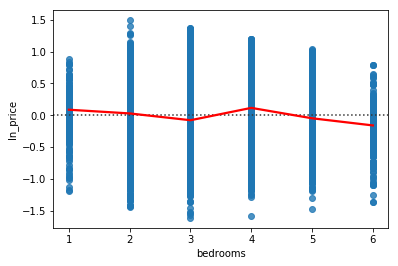

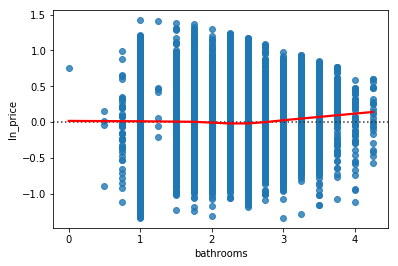

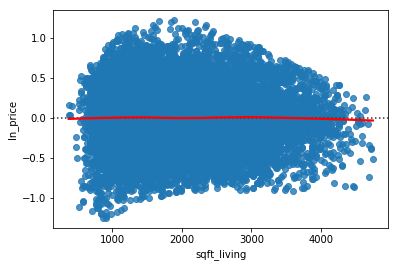

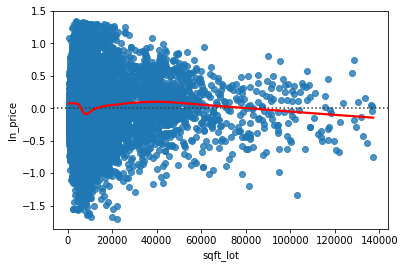

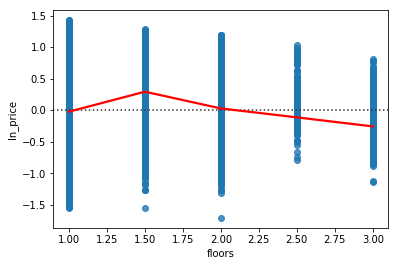

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


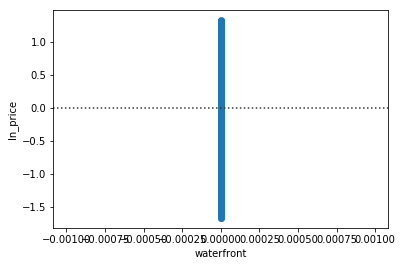

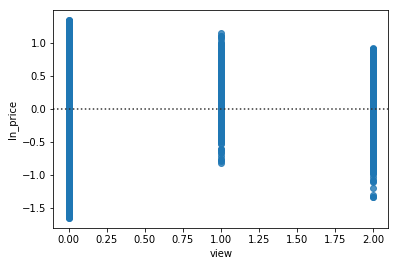

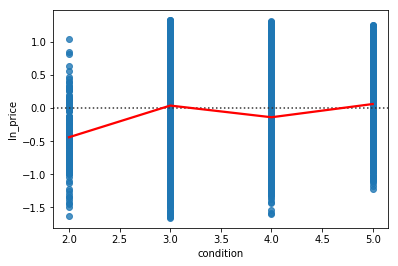

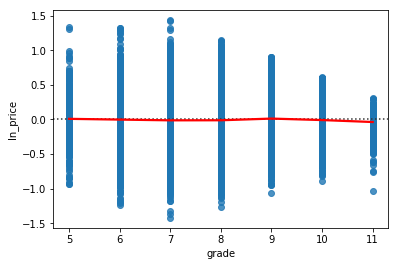

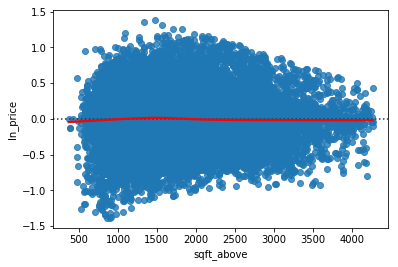

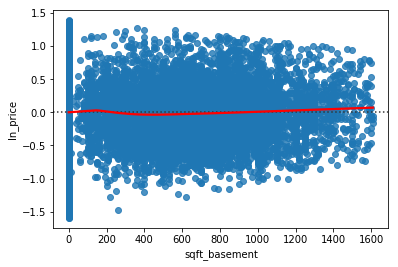

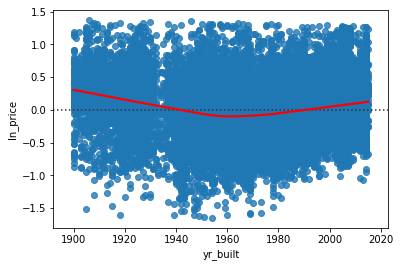

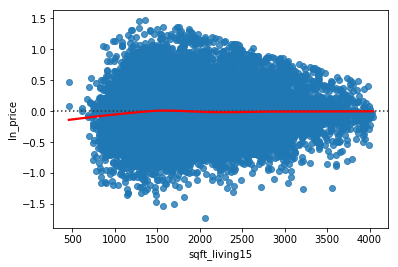

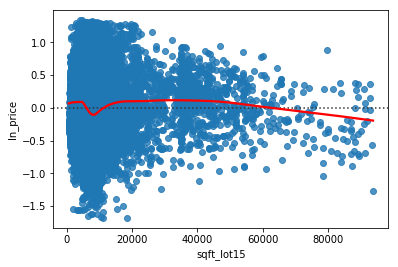

In [20]:
for feature in features:
    sns.residplot(X[feature], y, lowess=True, line_kws=dict(color='r'))
    plt.show()

From our residual plots, I think we can suspect that sqft_lot sqft_lot15 and yr_built all might be candidates for polynomial forms. Lets generate some squared terms and then re-plot the residuals graphs and see if we get any improvement.

In [0]:
df['sqft_lot_squared'] = df['sqft_lot']**2
df['sqft_lot15_squared'] = df['sqft_lot15']**2

Lets also create a few features from our eyeball test and we'll see which ones seem to be more statistically significant.

In [0]:
df['sqft_living_squared'] = df['sqft_living']**2

Lets add these to our regression and run it again to see if it has any considerable impact on coefficients.

In [25]:
# log-polynomial? linear regression model with robust standard errors 

# to use Robust Standard Errors pass:
# cov_type='HC3' parameter to .fit() function

X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_squared',
       'sqft_lot', 'sqft_lot_squared', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'sqft_lot15_squared']] 

y = df['ln_price']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     1779.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        17:54:00   Log-Likelihood:                -5663.3
No. Observations:               19628   AIC:                         1.136e+04
Df Residuals:                   19613   BIC:                         1.147e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.8478    

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


In [26]:
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_squared',
       'sqft_lot', 'sqft_lot_squared', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'sqft_living15',
       'sqft_lot15']]

y = df['ln_price']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     1730.
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        17:54:13   Log-Likelihood:                -5744.0
No. Observations:               19628   AIC:                         1.152e+04
Df Residuals:                   19614   BIC:                         1.163e+04
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.8275    

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
